# Work out dead time from a 2-Pulser technique 

Müller JW. Dead-time problems. Nuclear Instruments and Methods. 1973;112(1):47-57. (http://www.sciencedirect.com/science/article/pii/0029554X73907738)

http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.464.8888&rep=rep1&type=pdf

Costrell L. Accurate determination of the dead-time and recovery characteristics of Geiger Muller counters. Jour Res Nat Bur Stand. 1949;42:241-51. (http://nvlpubs.nist.gov/nistpubs/jres/42/jresv42n3p241_A1b.pdf)

Pommé S, Fitzgerald R, Keightley J. Uncertainty of nuclear counting. Metrologia. 2015;52(3):S3. (http://iopscience.iop.org/article/10.1088/0026-1394/52/3/S3/meta)

In [1]:
%matplotlib inline

from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as mc
import spacepy.toolbox as tb
import spacepy.plot as spp
import tqdm
from scipy import stats
import seaborn as sns
sns.set(font_scale=1.5)
# matplotlib.pyplot.rc('figure', figsize=(10,10))
# matplotlib.pyplot.rc('lines', lw=3)
# matplotlib.pyplot.rc('font', size=20)



%matplotlib inline

This unreleased version of SpacePy is not supported by the SpacePy team.


In [2]:
deadtime1 = 0.005 # small dead time
deadtime2 = 0.1   # large dead time



In a region where frequency, $\nu < 1/(2\tau)$ we get a value of the dead time regardless of what type it is.  

In [3]:
def freq_limit(tau):
    return 1/(2*tau)
print("Low deadtime freq limit is: ", freq_limit(deadtime1))
print("High deadtime freq limit is: ", freq_limit(deadtime2))

Low deadtime freq limit is:  100.0
High deadtime freq limit is:  5.0


## Low deadtime case

So with frequencies below the cutoff the formula is:

$\tau = \frac{t}{2} \frac{n_1+n_2-n_{sup}}{n_1n_2}$

Where $n_x$ are the counts per acculation period


In [4]:
# make one at 90 and one at 70
pulser1 = np.linspace(0, 400, 400*90)
pulser2 = np.linspace(0, 400, 400*70)
# these are times so we can deadtime correct each one

    


In [5]:
def deadtime_correct(data, deadtime):
    """
    input is a list of times, measurements are assumed in unit 1 bins
    """
    out = []
    out.append(data[0])
    for ii in range(1, len(data)):
        if data[ii] - out[-1] >= deadtime:
            out.append(data[ii])
    return np.asarray(out)
        
        

In [6]:

pulser1_td1 = deadtime_correct(pulser1, deadtime1)   
pulser2_td1 = deadtime_correct(pulser2, deadtime1)   



In [7]:
pulser12 = np.sort(np.append(pulser1, pulser2))
pulser12_td1 = deadtime_correct(pulser12, deadtime1)   


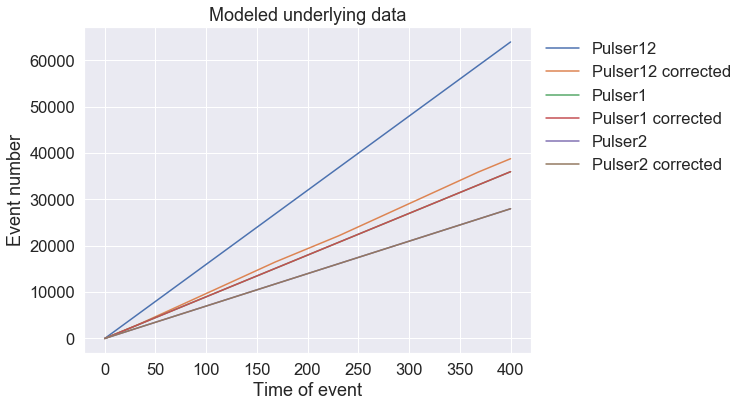

In [8]:
plt.figure(figsize=(8,6))
plt.plot(pulser12, np.arange(len(pulser12)), label='Pulser12')
plt.plot(pulser12_td1, np.arange(len(pulser12_td1)), label='Pulser12 corrected')

plt.plot(pulser1, np.arange(len(pulser1)), label='Pulser1')
plt.plot(pulser1_td1, np.arange(len(pulser1_td1)), label='Pulser1 corrected')

plt.plot(pulser2, np.arange(len(pulser2)), label='Pulser2')
plt.plot(pulser2_td1, np.arange(len(pulser2_td1)), label='Pulser2 corrected')

plt.xlabel('Time of event')
plt.ylabel('Event number')
plt.title("Modeled underlying data")

plt.legend(bbox_to_anchor=(1, 1))

So now determine the deadtime using the formula.

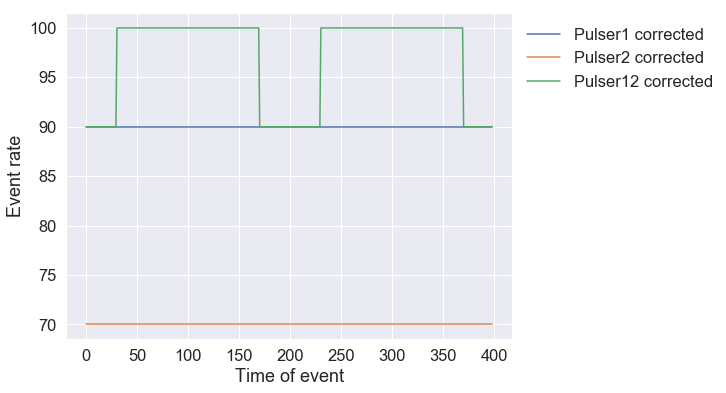

In [9]:
plt.figure(figsize=(8,6))

n1 = np.histogram(pulser1_td1, range(400))[0]
n2 = np.histogram(pulser2_td1, range(400))[0]
n12 = np.histogram(pulser12_td1, range(400))[0]

plt.plot(n1, label='Pulser1 corrected')
plt.plot(n2, label='Pulser2 corrected')
plt.plot(n12, label='Pulser12 corrected')
plt.xlabel('Time of event')
plt.ylabel('Event rate')


plt.legend(bbox_to_anchor=(1, 1))

In [10]:

tau1 = 0.5*(n1+n2-n12)/(n1*n2)

print("Calulated deadtime: {:.5}, input deadtime {}, relative difference {:.2}%".format(tau1.mean(), deadtime1, 
                                                                       ((tau1.mean()-deadtime1)/deadtime1)*100))

Calulated deadtime: 0.0049986, input deadtime 0.005, relative difference -0.028%


### Turn up the frequency and see which type the dead time is

In [11]:
# make one at 90 and one at 70
pulser1 = np.linspace(0, 400, 400*250)
pulser2 = np.linspace(0, 400, 400*220)
# these are times so we can deadtime correct each one

    


In [12]:

pulser1_td1 = deadtime_correct(pulser1, deadtime1)   
pulser2_td1 = deadtime_correct(pulser2, deadtime1)   



In [13]:
pulser12 = np.sort(np.append(pulser1, pulser2))
pulser12_td1 = deadtime_correct(pulser12, deadtime1)   


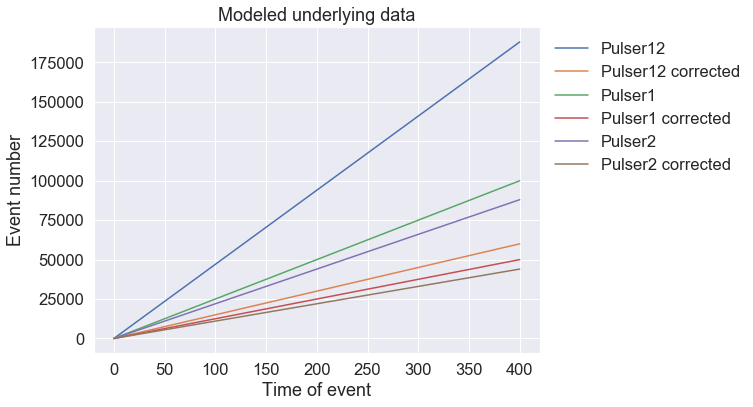

In [14]:
plt.figure(figsize=(8,6))
plt.plot(pulser12, np.arange(len(pulser12)), label='Pulser12')
plt.plot(pulser12_td1, np.arange(len(pulser12_td1)), label='Pulser12 corrected')

plt.plot(pulser1, np.arange(len(pulser1)), label='Pulser1')
plt.plot(pulser1_td1, np.arange(len(pulser1_td1)), label='Pulser1 corrected')

plt.plot(pulser2, np.arange(len(pulser2)), label='Pulser2')
plt.plot(pulser2_td1, np.arange(len(pulser2_td1)), label='Pulser2 corrected')

plt.xlabel('Time of event')
plt.ylabel('Event number')
plt.title("Modeled underlying data")

plt.legend(bbox_to_anchor=(1, 1))

So then if the deadtime is non-extending then the rate of pulser12 should be constant

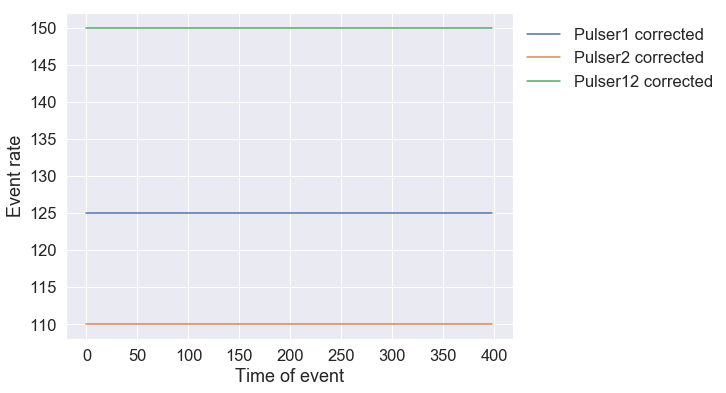

In [15]:
plt.figure(figsize=(8,6))

n1 = np.histogram(pulser1_td1, range(400))[0]
n2 = np.histogram(pulser2_td1, range(400))[0]
n12 = np.histogram(pulser12_td1, range(400))[0]

plt.plot(n1, label='Pulser1 corrected')
plt.plot(n2, label='Pulser2 corrected')
plt.plot(n12, label='Pulser12 corrected')
plt.xlabel('Time of event')
plt.ylabel('Event rate')


plt.legend(bbox_to_anchor=(1, 1))

Which it is

##  High deadtime case

In [16]:
# make one at 90 and one at 70
pulser1 = np.linspace(0, 400, 400*3)
pulser2 = np.linspace(0, 400, 400*4)
# these are times so we can deadtime correct each one

    


In [17]:

pulser1_td1 = deadtime_correct(pulser1, deadtime2)   
pulser2_td1 = deadtime_correct(pulser2, deadtime2)   



In [18]:
pulser12 = np.sort(np.append(pulser1, pulser2))
pulser12_td1 = deadtime_correct(pulser12, deadtime2)   


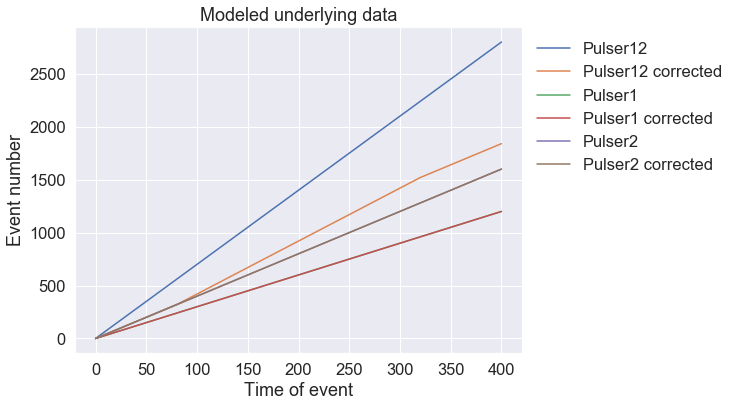

In [19]:
plt.figure(figsize=(8,6))
plt.plot(pulser12, np.arange(len(pulser12)), label='Pulser12')
plt.plot(pulser12_td1, np.arange(len(pulser12_td1)), label='Pulser12 corrected')

plt.plot(pulser1, np.arange(len(pulser1)), label='Pulser1')
plt.plot(pulser1_td1, np.arange(len(pulser1_td1)), label='Pulser1 corrected')

plt.plot(pulser2, np.arange(len(pulser2)), label='Pulser2')
plt.plot(pulser2_td1, np.arange(len(pulser2_td1)), label='Pulser2 corrected')

plt.xlabel('Time of event')
plt.ylabel('Event number')
plt.title("Modeled underlying data")

plt.legend(bbox_to_anchor=(1, 1))

So now determine the deadtime using the formula.

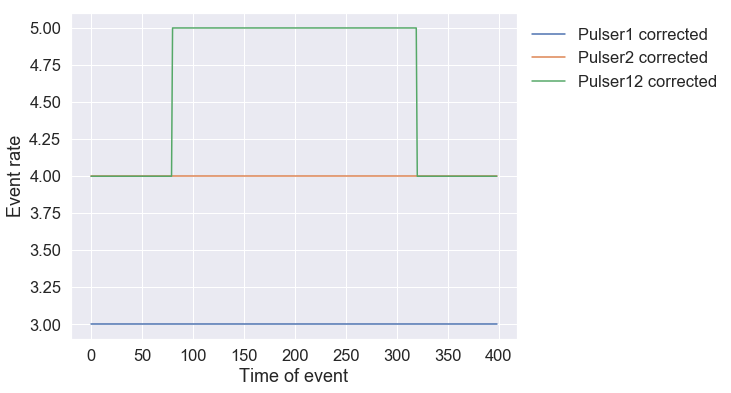

In [20]:
plt.figure(figsize=(8,6))

n1 = np.histogram(pulser1_td1, range(400))[0]
n2 = np.histogram(pulser2_td1, range(400))[0]
n12 = np.histogram(pulser12_td1, range(400))[0]

plt.plot(n1, label='Pulser1 corrected')
plt.plot(n2, label='Pulser2 corrected')
plt.plot(n12, label='Pulser12 corrected')
plt.xlabel('Time of event')
plt.ylabel('Event rate')


plt.legend(bbox_to_anchor=(1, 1))

In [21]:

tau1 = 0.5*(n1+n2-n12)/(n1*n2)

print("Calulated deadtime: {:.5}, input deadtime {}, relative difference {:.2}%".format(tau1.mean(), deadtime2, 
                                                                       ((tau1.mean()-deadtime2)/deadtime2)*100))

Calulated deadtime: 0.099937, input deadtime 0.1, relative difference -0.063%


###

# So can we do this with some kind of MCMC for an error estimate?

Each pulser is time accurate to 1% in time


In [22]:
pulser1 = np.linspace(0, 400, 400*90)
pulser2 = np.linspace(0, 400, 400*70)
# but now for each measurement we move it left and right by 1% of dt

r1 = np.random.normal(loc=0, scale=0.0001*90, size=len(pulser1))
r2 = np.random.normal(loc=0, scale=0.0001*70, size=len(pulser2))

print(pulser1.shape, pulser2.shape)


(36000,) (28000,)


/Users/balarsen/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


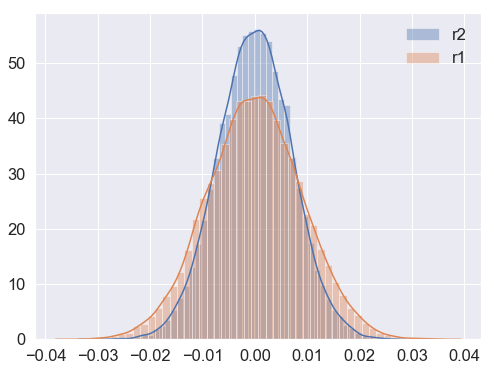

In [23]:
plt.figure(figsize=(8,6))
ax = plt.gca()
sns.distplot(r2, ax=ax, label='r2')
sns.distplot(r1, ax=ax, label='r1')
plt.legend(bbox_to_anchor=(1, 1))

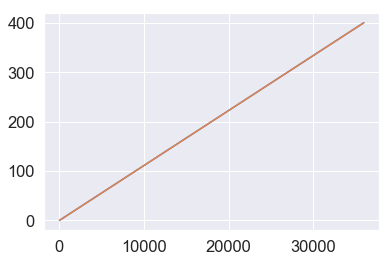

In [24]:
plt.plot(pulser1+r1)
plt.plot(pulser1)


In [25]:
print(pulser1.shape, pulser2.shape, pulser12.shape)
pulser1 += r1
pulser2 += r2
pulser12 = np.sort(np.append(pulser1, pulser2))

pulser1_dt = deadtime_correct(pulser1, deadtime1)   
pulser2_dt = deadtime_correct(pulser2, deadtime1)   
pulser12_dt = deadtime_correct(pulser12, deadtime1)   
print(pulser1.shape, pulser2.shape, pulser12.shape)
print(pulser1_dt.shape, pulser2_dt.shape, pulser12_dt.shape)


(36000,) (28000,) (2800,)
(36000,) (28000,) (64000,)
(23896,) (23111,) (37701,)


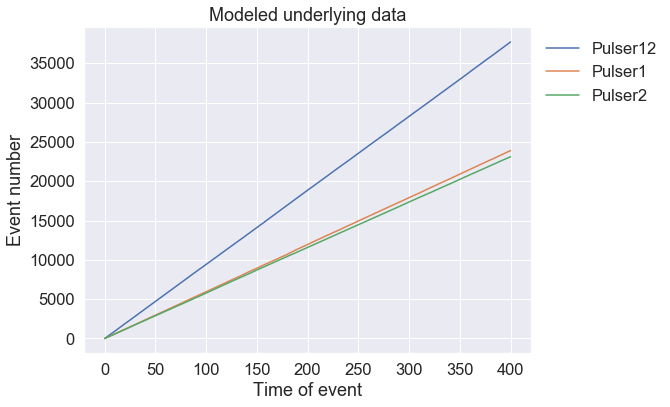

In [26]:
plt.figure(figsize=(8,6))

plt.plot(pulser12_dt, np.arange(len(pulser12_dt)), label='Pulser12')

plt.plot(pulser1_dt, np.arange(len(pulser1_dt)), label='Pulser1')

plt.plot(pulser2_dt, np.arange(len(pulser2_dt)), label='Pulser2')

plt.xlabel('Time of event')
plt.ylabel('Event number')
plt.title("Modeled underlying data")

plt.legend(bbox_to_anchor=(1, 1))

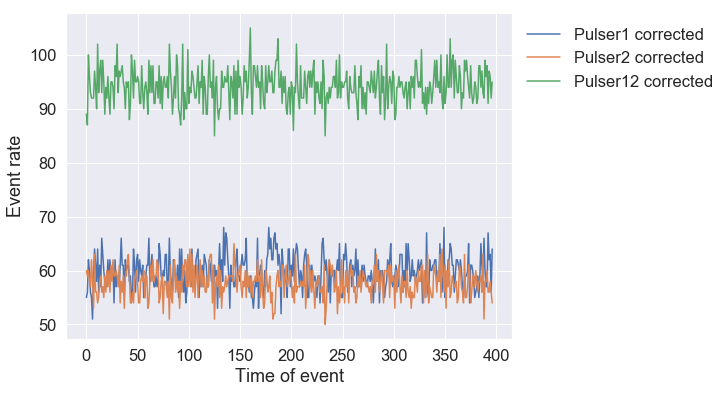

In [27]:
plt.figure(figsize=(8,6))

n1 = np.histogram(pulser1_dt, range(400))[0][2:]
n2 = np.histogram(pulser2_dt, range(400))[0][2:]
n12 = np.histogram(pulser12_dt, range(400))[0][2:]

plt.plot(n1, label='Pulser1 corrected')
plt.plot(n2, label='Pulser2 corrected')
plt.plot(n12, label='Pulser12 corrected')
plt.xlabel('Time of event')
plt.ylabel('Event rate')


plt.legend(bbox_to_anchor=(1, 1))

In [28]:

tau1 = 0.5*(n1+n2-n12)/(n1*n2)

print("Calulated deadtime: {:.5}, input deadtime {}, relative difference {}%".format(tau1.mean(), deadtime1, 
                                                                       ((tau1.mean()-deadtime1)/deadtime1)*100))

Calulated deadtime: 0.0033606, input deadtime 0.005, relative difference -32.78834392718387%
